In [1]:
import pymc3 as pm
import numpy as np
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from tvb.simulator.lab import *
from tvb_inversion.pymc3.prior import Pymc3Prior
from tvb_inversion.pymc3.stats_model import Pymc3Model
from tvb_inversion.pymc3.inference import EstimatorPYMC
from tvb_inversion.pymc3.stats_model_builder import DefaultStochasticPymc3ModelBuilder

%load_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/dionperd/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
#conn = connectivity.Connectivity.from_file()
conn = connectivity.Connectivity()
conn.weights = np.array([[0., 2.], [2., 0.]])
conn.region_labels = np.array(["R1", "R2"])
conn.centres = np.array([[0.1, 0.1, 0.1], [0.2, 0.1, 0.1]])
conn.tract_lengths = np.array([[0., 2.5], [2.5, 0.]])
conn.configure()

sim = simulator.Simulator(
    model=models.oscillator.Generic2dOscillator(a=np.array([1.5])),
    connectivity=conn,
    coupling=coupling.Difference(),
    integrator=integrators.HeunStochastic(
        dt=1.0,
        noise=noise.Additive(
            nsig=np.array([1e-4]),
            noise_seed=42
        )
    ),
    monitors=[monitors.Raw()],
    simulation_length = 250
)

In [3]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 87108cea-9e32-4c93-ae68-7a39d804fc1d
coupling,Difference gid: 3c476263-afc3-4122-99bb-cc05f9be7680
gid,UUID('fc7365e2-58d3-4d4b-8d6e-35398ee5a49b')
initial_conditions,None
integrator,HeunStochastic gid: ef09b6e5-9686-497a-b759-112c5fb38f2f
model,Generic2dOscillator gid: 863b7569-8023-45b5-9447-db1a71f2f49d
monitors,[]
simulation_length,250.0


In [4]:
sim.initial_conditions = np.zeros((conn.horizon, sim.model.nvar, conn.number_of_regions, 1))

In [5]:
sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 87108cea-9e32-4c93-ae68-7a39d804fc1d
coupling,Difference gid: 3c476263-afc3-4122-99bb-cc05f9be7680
gid,UUID('fc7365e2-58d3-4d4b-8d6e-35398ee5a49b')
"initial_conditions [min, median, max]","[0, 0, 0]"
initial_conditions dtype,float64
initial_conditions shape,"(2, 2, 2, 1)"
integrator,HeunStochastic gid: ef09b6e5-9686-497a-b759-112c5fb38f2f
model,Generic2dOscillator gid: 863b7569-8023-45b5-9447-db1a71f2f49d


In [6]:
(t, X), = sim.run()

In [7]:
X.shape

(250, 2, 2, 1)

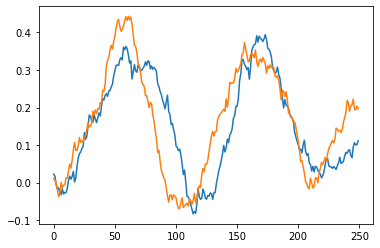

In [8]:
plt.plot(X[:, 0, :, 0]);

In [9]:
def_std = 0.1

model = pm.Model()
with model:
    a_model_star = pm.Normal(name="a_model_star", mu=0.0, sd=1.0, shape=sim.model.a.shape)
    a_model = pm.Deterministic(name="a_model", var=sim.model.a + def_std * a_model_star)
    
    a_coupling_star = pm.Normal(name="a_coupling_star", mu=0.0, sd=1.0)
    a_coupling = pm.Deterministic(name="a_coupling", 
                                  var=sim.coupling.a[0].item() + def_std * a_coupling_star)
    

In [10]:
prior = Pymc3Prior(
    model=model,
    names=["model.a", "coupling.a"], 
    dist=[a_model, a_coupling]
)

In [12]:
model_builder = DefaultStochasticPymc3ModelBuilder(sim=sim, params=prior, observation=X[:, :, :, 0])


In [13]:
model_builder.set_default_prior(def_std=def_std)

['model.a', 'coupling.a', 'x_init', 'integrator.noise.nsig', 'dWt_star', 'observation.model.amplitude', 'observation.model.offset', 'observation.noise'], [a_model ~ Deterministic, a_coupling ~ Deterministic, x_init ~ Deterministic, nsig ~ Deterministic, dWt_star ~ Normal, observation_model_amplitude ~ Deterministic, observation_model_offset ~ Deterministic, observation_noise ~ Deterministic]

In [14]:
model_builder.compose_model()

In [16]:
pymc_model = model_builder.build()

In [17]:
pymc_model.model

In [18]:
pymc_estimator = EstimatorPYMC(stats_model=pymc_model)

In [19]:
draws = 500
tune = 500
cores = 2

In [ ]:
inference_data = pymc_estimator.run_inference(draws, tune, cores, target_accept=0.9)

/Users/dionperd/Software/TVB/tvb-inversion/tvb_inversion/pymc3/inference.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=draws, tune=tune, cores=cores, target_accept=target_accept)
Auto-assigning NUTS sampler...


06-12-2022 05:11:54 - INFO - pymc3 - Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


06-12-2022 05:11:54 - INFO - pymc3 - Initializing NUTS using jitter+adapt_diag...


In [ ]:
init_params = {
    #"a_model": sim.model.a[0],
    "a_coupling": sim.coupling.a[0],
    "noise_gfun": sim.integrator.noise.gfun(None)[0],
    "global_noise": 0.0
}

In [ ]:
pymc_estimator.plot_posterior_samples(init_params)

In [ ]:
posterior_x_obs = inference_data.posterior_predictive.x_obs.values.reshape((cores*draws, *X.shape[:-1]))

In [ ]:
f3, axes3 = plt.subplots(nrows=2, ncols=1, figsize=(18,15))
axes3[0].plot(np.percentile(posterior_x_obs[:, :, 0, 0], [2.5, 97.5], axis=0).T, 
              "k", label=r"$V_{95\% PP}(t)$")
axes3[0].plot(X[:, 0, 0, 0], label="V_observed")
axes3[0].legend(fontsize=16)
axes3[0].set_xlabel("time (ms)", fontsize=16)
axes3[0].tick_params(axis="both", labelsize=16)

axes3[1].plot(np.percentile(posterior_x_obs[:, :, 0, 1], [2.5, 97.5], axis=0).T, 
         "k", label=r"$W_{95\% PP}(t)$")
axes3[1].plot(X[:, 0, 1, 0], label="W_observed")
axes3[1].legend(fontsize=16)
axes3[1].set_xlabel("time (ms)", fontsize=16)
axes3[1].tick_params(axis="both", labelsize=16)

plt.show()

In [ ]:
pymc_estimator.inference_summary.loc[["a_model", "a_coupling", "global_noise", "noise_gfun"]]

In [ ]:
pymc_estimator.inference_data.to_netcdf(filename="pymc3_data/test1.nc", compress=False)